In [1]:
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp

--2020-02-10 14:42:31--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.15.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.15.126|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘/tmp/train-balanced-sarcasm.csv’ not modified on server. Omitting download.



# Additional dependencies
You will need to have tensorflow keras pydot and graphviz in your OS  installed and added to the path  
```bash
python -m pip install  pydot
```

```bash
yay graphviz 

```bash
sudo apt install python-pydot python-pydot-ng graphviz
```

In [1]:
import os
import sys
import time
import warnings

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
packages = [
    'JohnSnowLabs:spark-nlp: 2.4.2'
]
spark = SparkSession \
    .builder \
    .appName("ML SQL session") \
    .config('spark.jars.packages', ','.join(packages)) \
    .config("spark.driver.memory","2g") \
    .getOrCreate()

In [2]:
import sparknlp

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:   2.4.2
Apache Spark version:  2.4.4


In [3]:
from pyspark.sql import SQLContext

sql = SQLContext(spark)

trainBalancedSarcasmDF = spark.read.option("header", True).option("inferSchema", True) \
    .csv("/tmp/train-balanced-sarcasm.csv")
trainBalancedSarcasmDF.printSchema()

# Let's create a temp view (table) for our SQL queries
trainBalancedSarcasmDF.createOrReplaceTempView('sarcasm')

sql.sql('SELECT COUNT(*) FROM sarcasm').collect()

root
 |-- label: integer (nullable = true)
 |-- comment: string (nullable = true)
 |-- author: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: string (nullable = true)
 |-- ups: string (nullable = true)
 |-- downs: string (nullable = true)
 |-- date: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- parent_comment: string (nullable = true)



[Row(count(1)=1010826)]

In [5]:
df = sql.sql('''
select label, concat(parent_comment,"\n",comment) as comment 
from sarcasm 
where comment is not null and parent_comment is not null limit 100000''')
print(type(df))
df.printSchema()
print('rows', df.count())
df = df.limit(2000) #minimize dataset if you are not running on a cluster
df.show()


<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- label: integer (nullable = true)
 |-- comment: string (nullable = true)

rows 100000
+-----+--------------------+
|label|             comment|
+-----+--------------------+
|    0|Yeah, I get that ...|
|    0|The blazers and M...|
|    0|They're favored t...|
|    0|deadass don't kil...|
|    0|Yep can confirm I...|
|    0|do you find arian...|
|    0|What's your weird...|
|    0|Probably Sephirot...|
|    0|What to upgrade? ...|
|    0|Probably count Ka...|
|    0|I bet if that mon...|
|    0|James Shields Wil...|
|    0|There's no time t...|
|    0|Team Specific Thr...|
|    0|Ill give you a hi...|
|    0|Star Wars, easy. ...|
|    0|You're adorable.
...|
|    0|He actually acts ...|
|    0|Clinton struggles...|
|    0|Is that the Older...|
+-----+--------------------+
only showing top 20 rows



In [14]:
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

from pyspark.ml import Pipeline

document_assembler = DocumentAssembler() \
    .setInputCol("comment") \
    .setOutputCol("document")
    
sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence") \
    .setUseAbbreviations(True)
    
tokenizer = Tokenizer() \
  .setInputCols(["sentence"]) \
  .setOutputCol("token")

nlp_pipeline = Pipeline(stages=[document_assembler, sentence_detector, tokenizer])
nlp_model = nlp_pipeline.fit(df)

processed = nlp_model.transform(df)
processed.show()

train, test = processed.randomSplit(weights=[0.7, 0.3], seed=123)

print(train.count())
print(test.count())

+-----+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|
+-----+--------------------+--------------------+--------------------+--------------------+
|    0|Yeah, I get that ...|[[document, 0, 90...|[[document, 0, 25...|[[token, 0, 3, Ye...|
|    0|The blazers and M...|[[document, 0, 20...|[[document, 0, 13...|[[token, 0, 2, Th...|
|    0|They're favored t...|[[document, 0, 14...|[[document, 0, 22...|[[token, 0, 6, Th...|
|    0|deadass don't kil...|[[document, 0, 90...|[[document, 0, 90...|[[token, 0, 6, de...|
|    0|Yep can confirm I...|[[document, 0, 11...|[[document, 0, 48...|[[token, 0, 2, Ye...|
|    0|do you find arian...|[[document, 0, 14...|[[document, 0, 14...|[[token, 0, 1, do...|
|    0|What's your weird...|[[document, 0, 98...|[[document, 0, 52...|[[token, 0, 5, Wh...|
|    0|Probably Sephirot...|[[document, 0, 14...|[[document, 0, 18...|[[token, 0

In [16]:
glove = WordEmbeddingsModel.pretrained()
train_featurized = glove.transform(train)
train_featurized.show()

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|          embeddings|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|"""Agreed. I thin...|[[document, 0, 13...|[[document, 0, 9,...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""It's kind of h...|[[document, 0, 11...|[[document, 0, 11...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""People""
Umm, ...|[[document, 0, 54...|[[document, 0, 54...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""QR Code""
"For...|[[document, 0, 73...|[[document, 0, 73...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""You are like t...|[[document, 0, 71...|[[document, 0, 71...|[[token, 0, 2, ""...|[[word_embeddings...|

In [17]:
test_featurized = glove.transform(test)
test_featurized.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|            document|            sentence|               token|          embeddings|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|"""Did Hillary Cl...|[[document, 0, 24...|[[document, 0, 10...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""Gingrich
And C...|[[document, 0, 98...|[[document, 0, 98...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"""Hey you wanna ...|[[document, 0, 77...|[[document, 0, 74...|[[token, 0, 2, ""...|[[word_embeddings...|
|    0|"*Danny reaches f...|[[document, 0, 10...|[[document, 0, 63...|[[token, 0, 1, "*...|[[word_embeddings...|
|    0|"@Senator_Assange...|[[document, 0, 18...|[[document, 0, 13...|[[token, 0, 0, ",...|[[word_embeddings...|
|    0|"Can we have a ""...|[[document, 0, 18...|[[document, 0, 56...|[[token, 0, 0, ",...|[[wor

In [18]:
def get_features(row):
    result = []
    for tk in row:
        result.append(tk['embeddings'])
    return np.array(result)

def build_data(df, chunks=10):
    x_train = []
    y_train = []

    row_count = df.count()
    i = 0
    
    chunks = df.randomSplit(weights=[1/chunks] * chunks)

    for chunk in chunks:
        rows = chunk.collect()
        for row in rows:
            if i % 1000 == 0:
                print('row {} / {} ({:.1f} %)'.format(i, row_count, 100 * i / row_count))
            embeddings = get_features(row['embeddings'])
            label = row['label']
            x_train.append(embeddings)
            y_train.append(label)
            i += 1

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    return x_train, y_train

In [19]:
x_train, y_train = build_data(train_featurized)

row 0 / 709 (0.0 %)


In [20]:
x_test, y_test = build_data(test_featurized)

row 0 / 291 (0.0 %)


In [21]:
spark.stop()

In [22]:
print('Train Labels:\n', pd.Series(y_train).value_counts())
print('Test Labels:\n', pd.Series(y_test).value_counts())

Train Labels:
 0    663
1     46
dtype: int64
Test Labels:
 0    277
1     14
dtype: int64


In [23]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

# set parameters for our model:
maxlen = 100 #max 50 words per article
batch_size = 32 #size of the batch 
filters = 50 #dimension of filters for the convolutional layer
kernel_size = 3 #size of the kernel used in the convolutional layer
hidden_dims = 250 #dimension of the hidden layer
epochs = 5 #number of training epochs

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

Using TensorFlow backend.


In [24]:
print('Build model...')
model = Sequential()

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

from keras import backend as K


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mae'])

Build model...


In [25]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 709 samples, validate on 291 samples
Epoch 1/5
709/709 [==============================] - 2s 2ms/step - loss: 0.3482 - accuracy: 0.8942 - mae: 0.1879 - val_loss: 0.1974 - val_accuracy: 0.9519 - val_mae: 0.0865
Epoch 2/5
709/709 [==============================] - 0s 325us/step - loss: 0.2448 - accuracy: 0.9351 - mae: 0.1161 - val_loss: 0.2031 - val_accuracy: 0.9519 - val_mae: 0.1207
Epoch 3/5
709/709 [==============================] - 0s 327us/step - loss: 0.2370 - accuracy: 0.9351 - mae: 0.1306 - val_loss: 0.1979 - val_accuracy: 0.9519 - val_mae: 0.1036
Epoch 4/5
709/709 [==============================] - 0s 324us/step - loss: 0.2315 - accuracy: 0.9351 - mae: 0.1147 - val_loss: 0.2000 - val_accuracy: 0.9519 - val_mae: 0.1096
Epoch 5/5
709/709 [==============================] - 0s 338us/step - loss: 0.2221 - accuracy: 0.9351 - mae: 0.1145 - val_loss: 0.2047 - val_accuracy: 0.9519 - val_mae: 0.1199


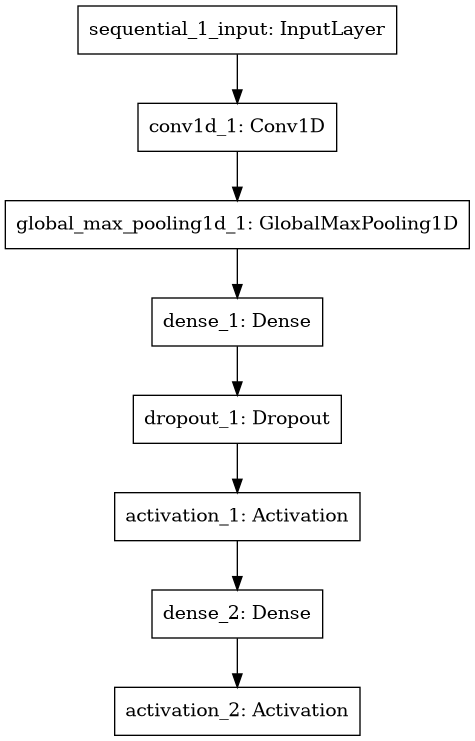

In [27]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
dot = model_to_dot(model)
Image(dot.create_png())